### This notebook is meant to find how positions are distributed over a 2-d space over the years 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from UtilFunctions import format_season, spearman_rank_corr


In [2]:
def pre_process(seasons):
    df = None
    for season in seasons:
        per_min_cols = ['FGA', '3PA', '2PA', 'PF', 'PTS', 'OWS', 'DWS', 'OBPM', 'DBPM', 'BPM']
        cols_to_drop = None
        first_year, second_year = format_season(season)
        player_data = pd.read_csv(f"DataCollection/Player_Stats/player_stats_{first_year}-{second_year}.csv")
        cols_to_drop = ['index', 'TRB', 'DRB', 'ORB', 'AST', 'G', 'GS', 'FT', 'FG', 'FG%', 'BLK', 'STL',
                                'WS', 'FTA', 'TOV', 'Age', '2P', '3P', 'VORP', 'Salary']
            
        player_data = player_data.fillna(0)
        player_data = player_data[(player_data["MP"] > 15) & (player_data["G"] >= 30)]
        player_data = player_data.sort_values(by=['G'], ascending=False)
        player_data = player_data[player_data["Tm"] != "TOT"]
        player_data = player_data.drop_duplicates(subset ="Player",keep = "first")
        player_data.reset_index(inplace=True)
        player_data.drop(columns=cols_to_drop, inplace=True)
        
        player_data['Season'] = season
        
        for col in per_min_cols:
            player_data[col] = player_data[col] / player_data['MP'] * 36
        
        if df is None:
            df = player_data
        else:
            df = pd.concat([df, player_data])
            
        
    df.reset_index(inplace=True)
    df.drop(['index'], axis=1, inplace=True)
    return df

In [3]:
def process_pca(df, feature_cols):
    #Select features
    features = df[feature_cols].values
    #z-normalize
    x = StandardScaler().fit_transform(features)
    
    #reduce dimensionality
    pca = PCA(n_components=2)
    components = pca.fit_transform(x)

    componentsDf = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
    componentsDf['Position'] = [i[1] for i in df.index]
    componentsDf['Season'] = [i[0] for i in df.index]
    print(pca.explained_variance_ratio_)

    return componentsDf, pca

In [4]:
def plot_pca(df, positions, features, pca, arrow_scale=8):
    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('Principal Component 1', fontsize=15)
    ax.set_ylabel('Principal Component 2', fontsize=15)
    ax.set_title('2 component PCA', fontsize=20)
    
    # Plot the data points
    for position in positions:
        ax.scatter(df[df['Position'] == position].loc[:, 'PC1'], df[df['Position'] == position].loc[:, 'PC2'], 
                   s=50, alpha=.8, label=position)
        for i, txt in enumerate(df[df['Position'] == position]['Season']):
            ax.annotate(txt, (df[df['Position'] == position].iloc[i]['PC1'], df[df['Position'] == position].iloc[i]['PC2']))
    
    magnitudes = np.sqrt(pca.components_[0, :]**2 + pca.components_[1, :]**2)
    
    # Get the indices of the top n features with the largest arrows
    top_indices = np.argsort(magnitudes)[:]
    
    # Plot the feature directions for the top 5 features
    for i in top_indices:
        feature = features[i]
        ax.arrow(0, 0, pca.components_[0, i] * arrow_scale, pca.components_[1, i] * arrow_scale, 
                 color='r', alpha=0.5, head_width=0.05, head_length=0.1)
        ax.text(pca.components_[0, i] * arrow_scale * 1.15, pca.components_[1, i] * arrow_scale * 1.15, 
                feature, color='black', ha='center', va='center', fontsize=12,
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    ax.legend()
    ax.grid()

In [5]:
def get_position_average_per_season(seasons):
    avg_by_pos = {}
    for season in seasons:
        df = pre_process([season])
        df.drop(['Player', 'Tm', 'Season'], axis=1, inplace=True)
        df.fillna(0, inplace=True)
        df = pd.DataFrame(df.groupby(by=['Pos']).mean())
        avg_by_pos[season] = df

    return avg_by_pos

### Turn each position, for each season, into an average of the whole position

In [6]:
player_data = pre_process(range(1980, 2025))

In [7]:
player_data[player_data['Player'] == 'Stephen Curry']

,Player,Pos,Tm,MP,FGA,3PA,3P%,2PA,2P%,eFG%,...,BLK%,TOV%,USG%,OWS,DWS,WS/48,OBPM,DBPM,BPM,Season
7201,Stephen Curry,PG,GSW,36.2,14.220994,4.773481,0.437,9.447514,0.474,0.535,...,0.5,16.5,21.8,2.983425,1.591160,0.077,1.093923,-0.497238,0.696133,2010
7523,Stephen Curry,PG,GSW,33.6,15.214286,4.928571,0.442,10.285714,0.498,0.551,...,0.6,16.4,24.4,5.785714,1.392857,0.128,3.214286,-0.750000,2.464286,2011
8049,Stephen Curry,PG,GSW,38.2,16.774869,7.256545,0.453,9.518325,0.449,0.549,...,0.3,13.7,26.4,7.916230,2.638743,0.180,4.994764,0.094241,5.089005,2013
8336,Stephen Curry,PG,GSW,36.5,17.457534,7.791781,0.424,9.665753,0.509,0.566,...,0.4,16.1,28.3,9.172603,3.945205,0.225,6.213699,1.084932,7.298630,2014
8578,Stephen Curry,PG,GSW,32.7,18.495413,8.917431,0.443,9.577982,0.528,0.594,...,0.5,14.3,28.9,12.660550,4.513761,0.288,9.027523,1.871560,10.899083,2015
8914,Stephen Curry,PG,GSW,34.2,21.263158,11.789474,0.454,9.473684,0.566,0.630,...,0.4,12.9,32.6,14.526316,4.315789,0.318,10.842105,1.684211,12.526316,2016
9188,Stephen Curry,PG,GSW,33.4,19.724551,10.778443,0.411,8.946108,0.537,0.580,...,0.5,13.0,30.1,9.377246,4.203593,0.229,7.221557,0.323353,7.437126,2017
9704,Stephen Curry,PG,GSW,32.0,19.012500,11.025000,0.423,7.987500,0.595,0.618,...,0.4,13.3,31.0,8.100000,2.137500,0.267,8.775000,0.000000,8.662500,2018
9889,Stephen Curry,PG,GSW,33.8,20.662722,12.461538,0.437,8.201183,0.525,0.604,...,0.9,11.6,30.4,7.668639,2.662722,0.199,7.562130,-0.532544,7.029586,2019
10449,Stephen Curry,PG,GSW,34.2,22.842105,13.368421,0.421,9.473684,0.569,0.605,...,0.3,12.2,34.8,6.842105,2.631579,0.201,8.736842,0.421053,9.157895,2021


In [8]:
avg_by_position = get_position_average_per_season(range(1980,2025))

In [9]:
merged_avg_by_position = pd.concat(avg_by_position.values(), keys=avg_by_position.keys())
merged_avg_by_position.columns

Index(['MP', 'FGA', '3PA', '3P%', '2PA', '2P%', 'eFG%', 'FT%', 'PF', 'PTS',
       'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM'],
      dtype='object')

[0.46799134 0.16597934]


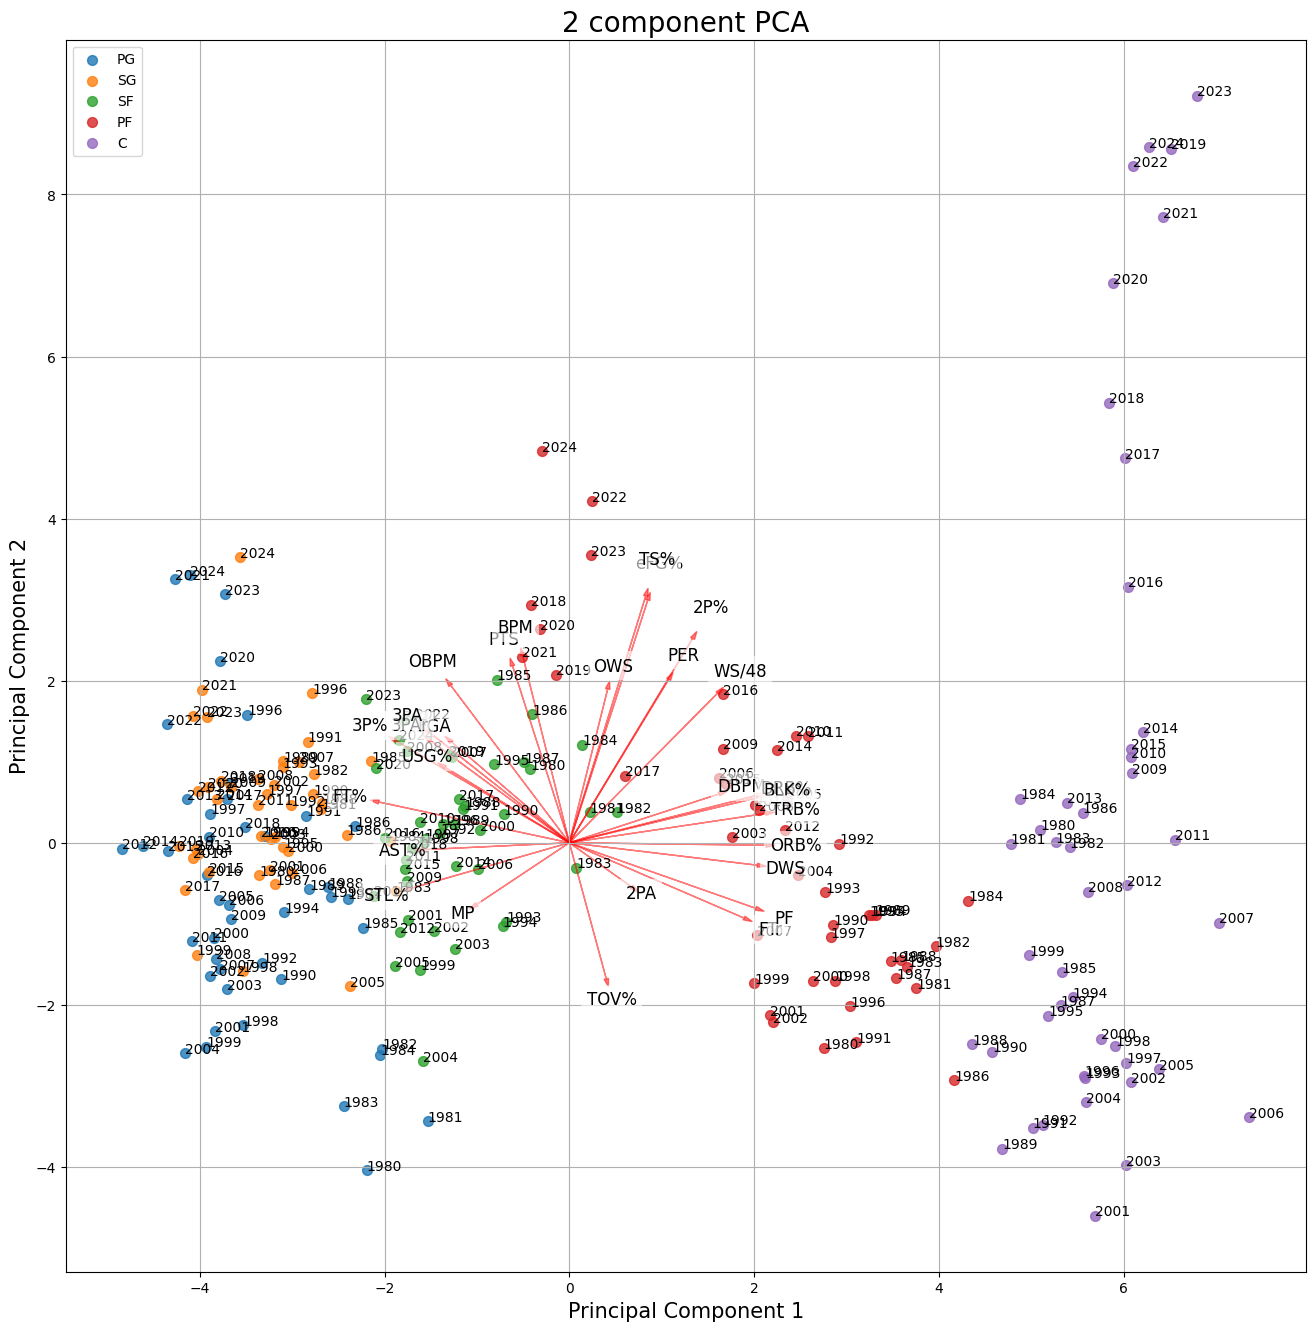

In [10]:
components_df, pca = process_pca(merged_avg_by_position, merged_avg_by_position.columns)

components_df.reset_index(inplace=True)
components_df.drop('index', axis=1, inplace=True)


# WILL BE USED IN THE ARTICLE
plot_pca(components_df, ['PG', 'SG', 'SF', 'PF', 'C'], merged_avg_by_position.columns, pca)

In [11]:
rank_correlations = {}

for position in ['PG', 'SG', 'SF', 'PF', 'C']:
    position_df = components_df[components_df['Position'] == position]
    pc2 = list(position_df['PC2'])
    seasons = list(position_df['Season'])
    pc2_rank = pd.Series(pc2).rank()
    seasons_rank = pd.Series(seasons).rank()

    spearman_corr = spearman_rank_corr(seasons_rank, pc2_rank)
    pearson_corr = np.corrcoef(seasons, pc2)[0, 1]

    rank_correlations[position] = {
        'spearman': spearman_corr,
        'pearson': pearson_corr
    }

    print(f'{position} PC2 rank correlation: Spearman: {spearman_corr}, Pearson: {pearson_corr}')

PG PC2 rank correlation: Spearman: 0.6208168642951252, Pearson: 0.6757852390458573
SG PC2 rank correlation: Spearman: 0.18063241106719363, Pearson: 0.24942141955219507
SF PC2 rank correlation: Spearman: -0.0022397891963108485, Pearson: 0.011569316816365223
PF PC2 rank correlation: Spearman: 0.824505928853755, Pearson: 0.84799110093013
C PC2 rank correlation: Spearman: 0.5603425559947299, Pearson: 0.6771504461674841


In [12]:
rank_correlations['SF']['spearman'] = 0.0

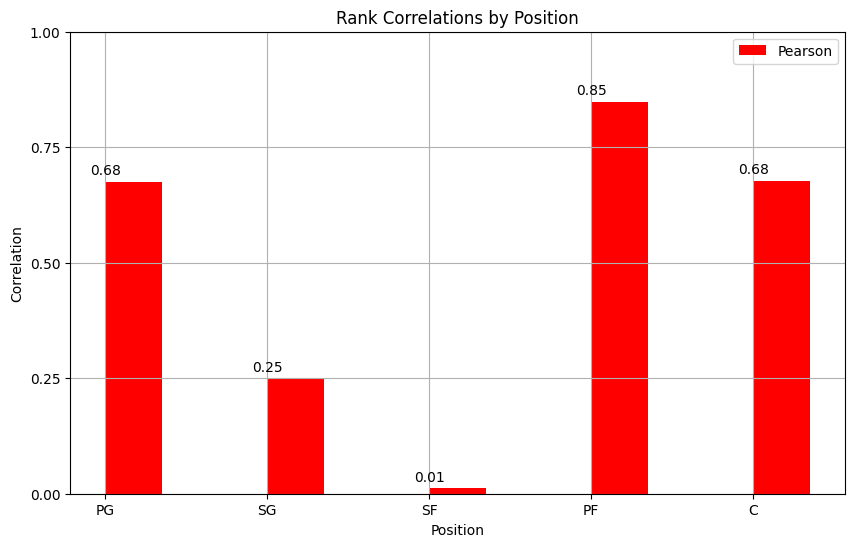

In [ ]:
import matplotlib.pyplot as plt

# Extract positions, spearman correlations, and pearson correlations
positions = list(rank_correlations.keys())
pearson_corrs = [rank_correlations[pos]['pearson'] for pos in positions]

# Set up the bar width and positions
bar_width = 0.35
index = np.arange(len(positions))

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

bar2 = ax.bar(index + bar_width, pearson_corrs, bar_width, label='Pearson', color='r')

# Add labels, title, and legend
ax.set_xlabel('Position')
ax.set_ylabel('Correlation')
ax.set_title('Rank Correlations by Position')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(positions)
ax.legend()
ax.grid()

for bar in bar2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x(), height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')


# Scale the y-axis
ax.set_ylim(0.0, 1)
ax.set_yticks(np.arange(0, 1.25, 0.25))

# Display the plot
plt.savefig('PCA_rank_correlations.png')
plt.show()

## WILL BE USED IN THE ARTICLE

In [14]:
def process_pca_by_season(df, season, feature_cols):
    #Select features
    features = df[feature_cols].values
    #z-normalize
    x = StandardScaler().fit_transform(features)
    
    #reduce dimensionality
    pca = PCA(n_components=2)
    components = pca.fit_transform(x)

    componentsDf = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
    componentsDf['Position'] = df.index
    componentsDf['Season'] = season

    print(f"Explained variation for season {season}: {pca.explained_variance_ratio_}")

    return componentsDf

In [15]:
components_df = pd.DataFrame(columns=['PC1', 'PC2', 'Position', 'Season'])
for k, v in avg_by_position.items():
    components_df = pd.concat([components_df, process_pca_by_season(v, k, v.columns)])
    
components_df.reset_index(inplace=True)
components_df.drop('index', axis=1, inplace=True)

plot_pca(components_df, ['PG', 'SG', 'SF', 'PF', 'C'])

Explained variation for season 1980: [0.59435289 0.27788177]
Explained variation for season 1981: [0.59061894 0.33746675]
Explained variation for season 1982: [0.64027989 0.27858055]
Explained variation for season 1983: [0.6925577  0.22891501]
Explained variation for season 1984: [0.63312405 0.28723597]
Explained variation for season 1985: [0.68169051 0.23995598]
Explained variation for season 1986: [0.63809607 0.17850036]
Explained variation for season 1987: [0.65305814 0.20410337]
Explained variation for season 1988: [0.68558112 0.1980547 ]
Explained variation for season 1989: [0.66115606 0.19407003]
Explained variation for season 1990: [0.66549617 0.28082207]
Explained variation for season 1991: [0.75784239 0.14660242]
Explained variation for season 1992: [0.62394711 0.2797807 ]
Explained variation for season 1993: [0.64646217 0.20002229]
Explained variation for season 1994: [0.69160333 0.19930016]
Explained variation for season 1995: [0.70029686 0.19341731]
Explained variation for 

C:\Users\mathe\AppData\Local\Temp\ipykernel_7960\2486047379.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  components_df = pd.concat([components_df, process_pca_by_season(v, k, v.columns)])


Explained variation for season 2000: [0.77056275 0.1847022 ]
Explained variation for season 2001: [0.68559974 0.21163725]
Explained variation for season 2002: [0.73075754 0.16241077]
Explained variation for season 2003: [0.66155984 0.23824084]
Explained variation for season 2004: [0.69774139 0.21587512]
Explained variation for season 2005: [0.67640212 0.19712908]
Explained variation for season 2006: [0.74991315 0.17811874]
Explained variation for season 2007: [0.77253605 0.1463508 ]
Explained variation for season 2008: [0.7251001  0.21566184]
Explained variation for season 2009: [0.76199562 0.11350439]
Explained variation for season 2010: [0.7529759  0.11924529]
Explained variation for season 2011: [0.76054503 0.12120704]
Explained variation for season 2012: [0.74650886 0.14681563]
Explained variation for season 2013: [0.69155993 0.19289883]
Explained variation for season 2014: [0.712398   0.17614098]
Explained variation for season 2015: [0.74453022 0.19226673]
Explained variation for 

TypeError: plot_pca() missing 2 required positional arguments: 'features' and 'pca'